## decovalex-jupyter-lab: DECOVALEX 2023: Task G: HM benchmarking
<img src="./d2023-jupyter-lab.png" width=400 height=60 />

### 1. Description
DECOVALEX is an international benchmarking project for the DEvelopment of COupled models and their VALidation against Experiments in geosystems with an emphasis on deep geological repositories (https://decovalex.org/). 
The present test case belongs to Task G (https://decovalex.org/D-2023/task-g.html) and is dealing with HM benchmarking. A detailed description is given at (link to manuscript).
<br>
<img src="./Model_sneddon_straight.png" width=200 height=60 />
<img src="./Model_propagating_straight.png" width=200 height=60 />
<img src="./model_real_static_straight_2.png" width=250 height=60 />
<img src="./model_real_static_inclined_2.png" width=250 height=60 />
<br>
jointly prepared by UFZ, KIGAM, Quintessa/UoE, TUBAF, ...

In [1]:
#from sympy import *
import numpy as np
#init_printing()
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import math 
import subprocess
import os
import scipy.optimize as opt
from numpy import exp
import timeit
from scipy.optimize import fsolve
#import sympy as sym
pi = math.pi
%matplotlib inline

### 2. Sneddon's Analytical Solution

In [2]:
# Real values in SI units
E = 49.75e9 #Pa
nu=0.26
KI = 0.95e6 #Pa.m^0.5
Gc=KI**2*(1-nu**2)/E #
print('Gc=',Gc)
p=1e6

Gc= 16.914391959798994


\begin{equation} 
  u_y(x,0) = \frac{2\left(1-\nu^2\right) pa}{E} \sqrt{1-\frac{x^2}{a^2}}
\end{equation}

In [3]:
h=0.001
a=.2
ell = 2*h

a_eff = a*(1+pi*ell/(4.*a*(3*h/8./ell+1))) # Just for VPF
print(a_eff)

def sneddon(h,a_eff):
    x= np.linspace(-0.5*a_eff,0.5*a_eff,20)
    uy=[]
    for i in range(len(x)):
        uy.append(2*0.5*a_eff*(1-nu**2)*p/E*math.sqrt(1-((x[i])/(0.5*a_eff))**2))
        
    return x,uy

0.20132277585414307


## Benchmarks: HM processes
### Benchmark 1: Sneddon (Opening profile)

Running OGS Simulation <br>
<img src="./ogs-jupyter-lab.png" width=200 height=60 />

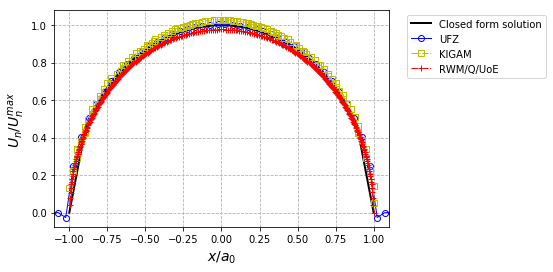

In [4]:
color=[ '-k','-bo','-.ys', '-.r+', '-.g*']
Label= ["Closed form solution",\
        "UFZ", \
        "KIGAM", "RWM/Q/UoE "]
lineWIDTH=[2,1,1,1,1,1,1,1,1,1]
#------------------------------------------------------------------------
inputfile = open('Sneddon_opening_UFZ.csv','r+')
data = [row.strip().split('\t') for row in inputfile]
opening_ufz = []
r_ufz = []

for i in range(len(data)):
    if i>1:
        r_ufz.append(float(data[i][0]))
        opening_ufz.append(float(data[i][3])) 
#------------------------------------------------------------------------
inputfile = open('Sneddon_opening_KIGAM.csv','r+')
data = [row.strip().split('\t') for row in inputfile]
opening_KIGAM = []
r_KIGAM = []

for i in range(len(data)):
    if i>1:
        r_KIGAM.append(float(data[i][0]))
        opening_KIGAM.append(float(data[i][2]))         
#------------------------------------------------------------------------
inputfile = open('Sneddon_opening_RWM_Q_UoE.csv','r+')
data = [row.strip().split(',') for row in inputfile]
opening_Q = []
r_Q = []

for i in range(len(data)):
    if i>1:
        r_Q.append(float(data[i][0]))
        opening_Q.append(float(data[i][1])) 

x_Sneddon=sneddon(h,a_eff)[0]
uy_Sneddon=sneddon(h,a_eff)[1]

Umax_ufz=2*0.5*a_eff*(1-nu**2)*p/E
UmaxKIGAM=2*0.5*a*(1-.15**2)*1./1.

plt.plot(np.array(x_Sneddon[:])/(0.5*a_eff), np.array(uy_Sneddon[:])/Umax_ufz, color[0],fillstyle='none' ,linewidth=lineWIDTH[0],label=Label[0])
plt.plot(np.array(r_ufz[:])/(0.5*a_eff), np.array(opening_ufz[:])/Umax_ufz, color[1],fillstyle='none' ,linewidth=lineWIDTH[1],label=Label[1])
plt.plot(np.array(r_KIGAM[:])/(0.5*a), np.array(opening_KIGAM[:])/UmaxKIGAM, color[2],fillstyle='none' ,linewidth=lineWIDTH[2],label=Label[2])
plt.plot(np.array(r_Q[:])/(0.5*a), 0.5*np.array(opening_Q[:])/Umax_ufz, color[3],fillstyle='none' ,linewidth=lineWIDTH[3],label=Label[3])
#------------------------------------------------------------------------
#plt.rcParams['figure.figsize'] = [20, 10] 
# plt.rcParams['figure.dpi'] = 800
plt.xlim([-1.1, 1.1])
plt.ylabel('$U_n/U_n^{max}$',fontsize =14)                   
plt.xlabel('$x/a_0$',fontsize =14)                
plt.grid(linestyle='dashed')    
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Sneddon_opening.png')

### Benchmark 2: Propagating straight fracture (pressure and crack length)

In [5]:
# Note: For this example, the variable could be normalized. The following is a scaling method.

E = 1.0
nu = 0.15
a0 = 0.10
Eprime = E/(1-nu**2)
G=1
h=0.001
l=2*h

#--------------------------------------------------------------------
# Effective Gc and a for AT1 (for VPF)
Gc_ref = G * (1+3*h/(8*l))
a =  a0 + (pi*l/4.)/(1+3*h/(8*l))
#--------------------------------------------------------------------
V_c = (4*pi*Gc_ref*a**3/Eprime)**0.5
P_c = (Eprime*Gc_ref/(pi*a))**0.5
print(P_c)

#--------------------------------------------------------------------
#UFZ results
file_075 = 'Propagating_UFZ_bl075.out'
input_075 = open(file_075,'r')
data_075 = [row.strip().split(' ') for row in input_075]
data_075, indices = np.unique(data_075, return_index=True)
temp=[]
for (i, id_data) in enumerate(data_075):
    if  i%2==1:
            temp.append((data_075[i][:]))
data_075=temp

v_pf = []
pres_pf = []
length_pf = []

v_075 = []
pres_075 = []
length_075 = []

for (i, id_data) in enumerate(data_075):
    if  i>0:
            v_075.append(float(data_075[i][0]))
            pres_075.append(float(data_075[i][1])/P_c)
            length_075.append(float(data_075[i][4])/Gc_ref/2)                        
        
#--------------------------------------------------------------------
#Analytical solution
v = np.linspace(1e-10,0.5,200)
pres = np.linspace(0,1.0,200)
length = np.linspace(0,1.0,200)

for i in range(len(v)):
    if v[i] < V_c:
        pres[i] = Eprime*v[i]/(2*pi*a**2)/P_c
        length[i] = a
    else:
        pres[i] = (2*Eprime*Gc_ref**2/(pi*v[i]))**0.333333/P_c
        length[i] = (Eprime*v[i]**2/(4*pi*Gc_ref))**0.333333



1.9535743755518218


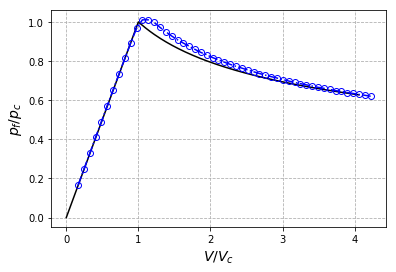

In [6]:
color=[ '-.bo', '-.r*', '-.g+']
Label= [ "UFZ"] 
lineWIDTH=[ 1,1,1]

plt.plot(np.array(v)/V_c, pres, 'black', label='Closed form (Sneddon)')
plt.plot(np.array(v_075)/V_c,pres_075 ,color[0],fillstyle='none', label=Label[0])




plt.grid(linestyle='dashed')   
plt.xlabel('$V/V_c$',fontsize =14)
plt.ylabel('$p_f/p_c$',fontsize =14)
# plt.xlim(0.0,0.5)
# plt.ylim(0.0,1.2)
plt.savefig('pres_verif_AT1.png')
# legend = plt.legend(loc='lower right')

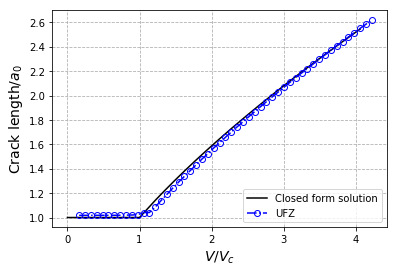

In [7]:
plt.plot(np.array(v)/V_c, np.array(length)/a, 'black', label='Closed form solution')
plt.plot(np.array(v_075)/V_c,np.array(length_075[:])/a0 ,color[0],fillstyle='none', label=Label[0])



plt.grid(linestyle='dashed')   
plt.xlabel('$V/V_c$',fontsize =14)
plt.ylabel('Crack length$/a_0$',fontsize =14)
#plt.xlim(0.0,0.5)
# plt.ylim(0.0,0.3)
plt.legend(loc='lower right')
plt.savefig('length_verif_AT1.png')

### Scaling
$\newcommand{\eps}{\varepsilon}$
$\DeclareMathOperator{\e}{{\rm e}}$

Then other dependent variables are scaled as
\begin{equation}
\label{eq:scaling_param_mech}
\vec{u} = u_o \vec{\tilde{u}}, \quad
E = E_o \tilde{E}, \quad
x = x_o \tilde{x}
\end{equation}

Post-procssing variables
\begin{align}
u_o = \sqrt{\frac{G_{co} x_o}{E_o}},  \quad
p_o = \sigma_0 = \sqrt{\frac{G_{co} E_o}{x_o}}
\end{align}

In [8]:
# Real values in SI units
E = 49.75e9 #Pa
nu=0.26
KI = 0.95e6 #Pa.m^0.5
#Gc=KI**2*(1-nu**2)/E #
Gc = 10000 # since it's a static fracture, we have used high value for Gc
print('Gc=',Gc)
p=12e6 #Pa internal pressure
a=.17 # fracture length
Eprime = E/(1-nu**2)
V_c = (4*pi*Gc*a**3/Eprime)**0.5
P_c = (Eprime*Gc/(pi*a))**0.5
print("P_c", P_c )
print("a", a )
x=0.5

#Input - normalizing parameters
Gc_o = Gc
x_o = 1
E_o = E

#Scaling paramaters 
u_o = np.sqrt(Gc_o*x_o/E_o)
p_o = np.sqrt(Gc_o*E_o/x_o)
beta_o = np.sqrt(Gc/(E*x_o))
#kappa_o = E_o

Ed = E/E_o
Sx = 5.e6
Sy = 10.e6

print('-----------------------------------------------')
print('E_sim=', Ed, 'Gc_sim=',Gc/Gc_o, 'x_sim=', x/x_o)
print('Sigma_scaling', p_o,  'Pressure_scaling=', p_o , 'Displacement_scaling=',u_o)
print('-----------------------------------------------')
print('Sy_sim = Sy_real/po=',(Sy)/p_o)
print('Sx_sim = Sx_real/po=',(Sx)/p_o)
print('p_sim = p_real/po=', p/p_o)


Gc= 10000
P_c 31607926.958476488
a 0.17
-----------------------------------------------
E_sim= 1.0 Gc_sim= 1.0 x_sim= 0.5
Sigma_scaling 22304708.02319546 Pressure_scaling= 22304708.02319546 Displacement_scaling= 0.00044833583966222035
-----------------------------------------------
Sy_sim = Sy_real/po= 0.44833583966222035
Sx_sim = Sx_real/po= 0.22416791983111017
p_sim = p_real/po= 0.5380030075946645


In [9]:
### Benchmark 3: Horizontal fracture

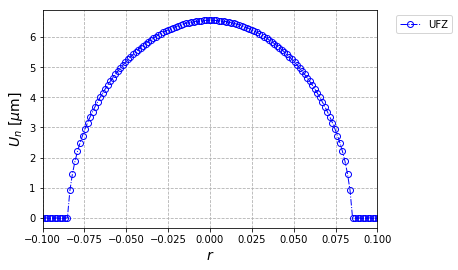

In [10]:
color=[ '-.bo', '-.r*', '-.g+']
Label= [ "UFZ"] 
lineWIDTH=[ 1,1,1]

inputfile_benchmark3  = open('OpeningParaView_0deg_h0p001.csv','r+')
data_benchmark3  = [row.strip().split('\t') for row in inputfile_benchmark3 ]
opening_ufz_benchmark3 = []
r_ufz_benchmark3  = []

for i in range(len(data_benchmark3 )):
    if i>1:
        r_ufz_benchmark3 .append(float(data_benchmark3 [i][0]))
        if float(data_benchmark3 [i][3])<0.:
            opening_ufz_benchmark3.append(0.) 
        else:
            opening_ufz_benchmark3.append(float(data_benchmark3 [i][3])) 
        
#Plot        
plt.plot(np.array(r_ufz_benchmark3[:]), np.array(opening_ufz_benchmark3[:])*u_o/1e-6, color[0],fillstyle='none' ,linewidth=lineWIDTH[0],label=Label[0])

#plt.rcParams['figure.figsize'] = [20, 10] 
# plt.rcParams['figure.dpi'] = 800
plt.xlim([-.1, 0.1])
plt.ylabel('$U_n$ [$\mu$m]',fontsize =14)                   
plt.xlabel('$r$',fontsize =14)                
plt.grid(linestyle='dashed')    

legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Straight_opening.png')          

In [11]:
### Benchmark 4: Inclined fracture

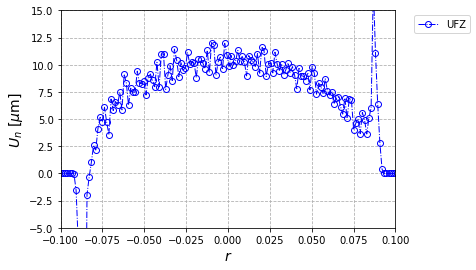

In [12]:
inputfile_benchmark4  = open('OpeningParaView_30deg_h0p001.csv','r+')
data_benchmark4  = [row.strip().split('\t') for row in inputfile_benchmark4 ]
opening_ufz_benchmark4 = []
r_ufz_benchmark4  = []


for i in range(len(data_benchmark4 )):
    if i>1:
        r_ufz_benchmark4 .append(float(data_benchmark4 [i][0]))
#         if float(data_benchmark4 [i][3])<0.:
#             opening_ufz_benchmark4 .append(0.) 
#         else:
        opening_ufz_benchmark4 .append(float(data_benchmark4 [i][3])) 

#--------------------------------------------------------------------        
plt.plot(np.array(r_ufz_benchmark4 [:]), np.array(opening_ufz_benchmark4 [:])*u_o/1e-6, color[0],fillstyle='none' ,linewidth=lineWIDTH[0],label=Label[0])

#plt.rcParams['figure.figsize'] = [20, 10] 
# plt.rcParams['figure.dpi'] = 800
plt.xlim([-.1, 0.1])
plt.ylim([-5, 15])


plt.ylabel('$U_n$ [$\mu$m]',fontsize =14)                   
plt.xlabel('$r$',fontsize =14)                
plt.grid(linestyle='dashed')    


legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('inclined_opening.png')  
        